In [64]:
from functools import partial
import sys, os, math, time, json
import numpy as np
from scipy.stats import ttest_ind
import tqdm
from matplotlib import pyplot as plt
%matplotlib notebook

import pandas as pd

import haiku as hk
import tree as dm_tree

import jax.numpy as jnp
import jax
import jax_bayes
jax.config.update('jax_platform_name', 'cpu') # for eval notebook

In [65]:
sys.path.append('../cifar10')
from cifar10_dataloader import get_cifar10_dataset, get_svhn_dataset

In [66]:
bn_config = dict(
  create_scale=True,
  create_offset=True,
  decay_rate=0.999,
  eps=1e-5
)

initial_conv_config = dict()
initial_conv_config["output_channels"] = 64
initial_conv_config["kernel_shape"] = 7
initial_conv_config["stride"] = 2
initial_conv_config["with_bias"] = False
initial_conv_config["padding"] = "SAME"

#define the net-function 
def net_fn(batch, is_training=True):
    net = hk.nets.ResNet18(10, #num classes
                            resnet_v2=True,
                            bn_config=bn_config,
                            initial_conv_config=initial_conv_config)
    x = batch['image']
    return net(x, is_training)

net = hk.transform_with_state(net_fn)

In [67]:
def accuracy(params, hk_state, batch):
    pred_fn = lambda p,s: net.apply(p, s, None, batch, is_training=False)
    pred_fn = jax.vmap(pred_fn)
    logits_samples, _ = pred_fn(params, hk_state)
    logits = jnp.mean(logits_samples, axis=0)
    return jnp.mean(jnp.argmax(logits, axis=-1) == batch['label'])
accuracy = jax.jit(accuracy, backend='cpu')

In [6]:
train_batches, test_batches = get_cifar10_dataset(256)

def eval_step(params, hk_state):
    tot_acc = 0
#     for i, batch in enumerate(test_batches):
    for i, batch in enumerate(tqdm.tqdm(test_batches)):
        tot_acc += accuracy(params, hk_state, batch)
    tot_acc = tot_acc / (i+1)
    return tot_acc

170499072it [00:21, 7788467.88it/s]                                                                                                                                                         


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [7]:
import pickle
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [7]:
RUN_DIR = 'runs/run_2022-04-19_22-00-58' # non-tempered
# RUN_DIR = 'runs/run_2022-04-18_11-10-21' # tempered
TGT_PARAM_PATH = os.path.join(RUN_DIR, 'tgt_params.pkl')
AUX_PARAM_PATH = os.path.join(RUN_DIR, 'aux_params.pkl')
TGT_STATE_PATH = os.path.join(RUN_DIR, 'hk_state.pkl')
AUX_STATE_PATH = os.path.join(RUN_DIR, 'aux_hk_state.pkl')

tgt_params = load_pickle(TGT_PARAM_PATH)
aux_params = load_pickle(AUX_PARAM_PATH)
hk_state = load_pickle(TGT_STATE_PATH)
aux_hk_state = load_pickle(AUX_STATE_PATH)

LOG_PATH = os.path.join(RUN_DIR, 'run.log')
with open(LOG_PATH, 'r') as f:
    log = [json.loads(line) for line in f]

In [62]:
print(eval_step(tgt_params, hk_state))

  0%|                                                                                                                                                                      | 0/39 [00:09<?, ?it/s]

KeyboardInterrupt



In [66]:
tmp_test_batch = next(iter(test_batches))
print(tmp_test_batch['image'].shape)

(256, 32, 32, 3)


In [ ]:
%matplotlib notebook

def do_uncertainty_analysis(params, state):
#     test_data = next(iter(test_batches))
    test_data = tmp_test_batch
    pred_fn = lambda p,s: net.apply(p, s, None, test_data, is_training=False)
    pred_fn = jax.vmap(pred_fn)

    all_test_logits, _ = pred_fn(params, state)
    probs = jnp.mean(jax.nn.softmax(all_test_logits, axis=-1), axis=0)
    correct_preds_mask = jnp.argmax(probs, axis=-1) == test_data['label']

    entropies = jax_bayes.utils.entropy(probs)
    correct_ent = entropies[correct_preds_mask]
    incorrect_ent = entropies[~correct_preds_mask]

    mean_correct_ent = jnp.mean(correct_ent)
    mean_incorrect_ent = jnp.mean(incorrect_ent)

    plt.hist(np.array(correct_ent), alpha=0.3, label='correct', density=True)
    plt.hist(np.array(incorrect_ent), alpha=0.3, label='incorrect', density=True)
    plt.axvline(x=mean_correct_ent, color='blue', label='mean correct')
    plt.axvline(x=mean_incorrect_ent, color='orange', label='mean incorrect')
    plt.legend()
    plt.xlabel("entropy")
    plt.ylabel("histogram density")
    plt.title("posterior predictive entropy of correct vs incorrect predictions")
    plt.show()

In [38]:
hparams, run_log = log[:1], log[1:]
print(hparams)
print(run_log[:5])
tgt_acc = [float(row['test_acc']) for row in run_log]
aux_acc = [float(row['aux_test_acc']) for row in run_log]
plt.plot(tgt_acc)
plt.plot(aux_acc)
plt.show()

[{'batch_size': 256, 'base_lr': 0.001, 'aux_lr': '0.001 * (0.1**jnp.floor_divide(i,2_000))', 'tgt_lr': 1e-07, 'reg': 0.0001, 'num_samples': 5, 'noise_scale': 0.0001, 'jump prob': '0.05', 'aux_inv_temp': 1.0, 'init_stdev': 0.001, 'tgt_sampler': 'langevin_fns', 'aux_sampler': 'rms_lanveginV2_fns'}]
[{'epoch': '0', 'tot_steps': '195.0', 'test_acc': '0.5081129670143127', 'aux_test_acc': '0.5143229365348816', 'aux_lr': '0.0010000000474974513'}, {'epoch': '1', 'tot_steps': '390.0', 'test_acc': '0.5549879670143127', 'aux_test_acc': '0.5071113705635071', 'aux_lr': '0.0010000000474974513'}, {'epoch': '2', 'tot_steps': '585.0', 'test_acc': '0.6291065812110901', 'aux_test_acc': '0.6087740659713745', 'aux_lr': '0.0010000000474974513'}, {'epoch': '3', 'tot_steps': '780.0', 'test_acc': '0.5878405570983887', 'aux_test_acc': '0.5732171535491943', 'aux_lr': '0.0010000000474974513'}, {'epoch': '4', 'tot_steps': '975.0', 'test_acc': '0.6265023946762085', 'aux_test_acc': '0.6213942170143127', 'aux_lr': '0

In [19]:
def get_all_run_logs(RUN_DIRS=None):
    if RUN_DIRS is None:
        RUN_DIRS = [
            '../cifar10/runs/run_2022-10-01_11-11-42',
            '../cifar10/runs/run_2022-10-01_11-58-55',
            '../cifar10/runs/run_2022-10-01_12-46-05',
            '../cifar10/runs/run_2022-10-01_13-33-15',
            '../cifar10/runs/run_2022-10-01_14-20-35'
        ]
    
    all_tgt_acc = []
    all_aux_acc = []
    ts = []
    for i, DIR in enumerate(RUN_DIRS):
        LOG_PATH = os.path.join(DIR, 'run.log')
        with open(LOG_PATH, 'r') as f:
            log = [json.loads(line) for line in f]

        hparams, run_log = log[:1], log[1:]
        tgt_test_acc = [float(row['test_acc']) for row in run_log]
        aux_test_acc = [float(row['aux_test_acc']) for row in run_log]
        if i == 0:
            ts = [int(row['epoch']) for row in run_log]
        all_tgt_acc.append(tgt_test_acc)
        all_aux_acc.append(aux_test_acc)
    
    print([len(x) for x in all_tgt_acc])
    
    assert len(set(len(x) for x in all_tgt_acc)) == 1
    assert len(set(len(x) for x in all_aux_acc)) == 1
    tgt_acc_df = pd.DataFrame(list(zip(*all_tgt_acc)), index=ts, columns=[f'seed{i}' for i in range(1, 6)])
    aux_acc_df = pd.DataFrame(list(zip(*all_aux_acc)), index=ts, columns=[f'seed{i}' for i in range(1, 6)])
    
    return tgt_acc_df, aux_acc_df

In [35]:
def plot_acc(ax, df, label=None, **plot_kwargs):
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    lower, upper = mean - std, mean + std

    xs = list(range(1, len(mean)+1))
    if 'color' in plot_kwargs:
        ax.fill_between(xs, lower, upper, alpha=0.3, color=plot_kwargs['color'], linewidth=0)
    else:
        ax.fill_between(xs, lower, upper, alpha=0.3)
    ax.plot(xs, mean, label=label, **plot_kwargs)
    
def plot_acc_ngrads(ax, df, label=None):
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    lower, upper = mean - std, mean + std

    if label in ['linear']:
        xs = mean.index * 60_000
    elif label in ['nonlinear (BG)']:
        xs = mean.index * 2 * 60_000
    ax.fill_between(xs, lower, upper, alpha=0.3)
    ax.plot(xs, mean, label=label)

[50, 50, 50, 50, 50]
tgt acc 0.8466546773910523 0.0022960534277763345
aux acc 0.8497396111488342 0.00048242927079067703


<IPython.core.display.Javascript object>


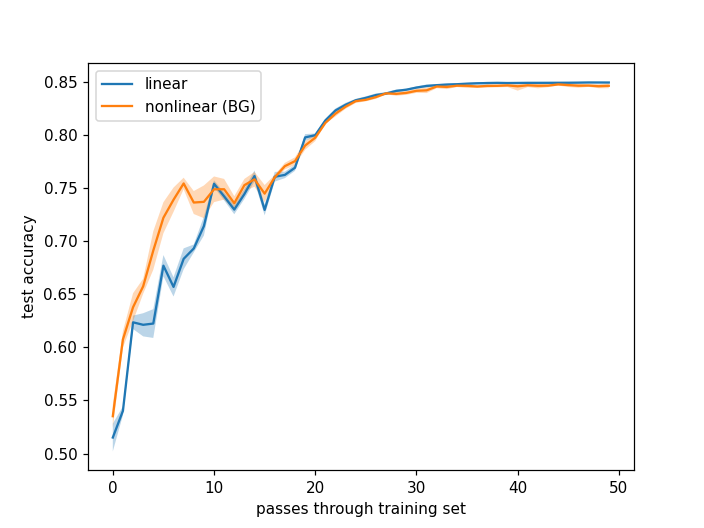

In [15]:
tgt_acc_df, aux_acc_df = get_all_run_logs()

print('tgt acc', tgt_acc_df.mean(axis=1).iloc[-1], tgt_acc_df.std(axis=1).iloc[-1])
print('aux acc', aux_acc_df.mean(axis=1).iloc[-1], aux_acc_df.std(axis=1).iloc[-1])

f, ax = plt.subplots()
plot_acc(ax, aux_acc_df, label='linear')
plot_acc(ax, tgt_acc_df, label='nonlinear (BG)')
ax.set_xlabel('passes through training set')
ax.set_ylabel('test accuracy')
ax.set
ax.legend()

[50, 50, 50, 50, 50]
[50, 50, 50, 50, 50]
tgt acc BG 0.8427684426307678 0.0028324157060406136
tgt acc AR 0.10170272588729859 0.0027771673195575897
aux acc 0.8491185903549194 0.0012073332168762172
bg vs linear 0.8491185903549194 0.8427684426307678 Ttest_indResult(statistic=4.611681892614376, pvalue=0.0017288649785905583)
ar vs linear 0.8491185903549194 0.10170272588729859 Ttest_indResult(statistic=551.89347874479, pvalue=1.3011724505001958e-19)


<IPython.core.display.Javascript object>


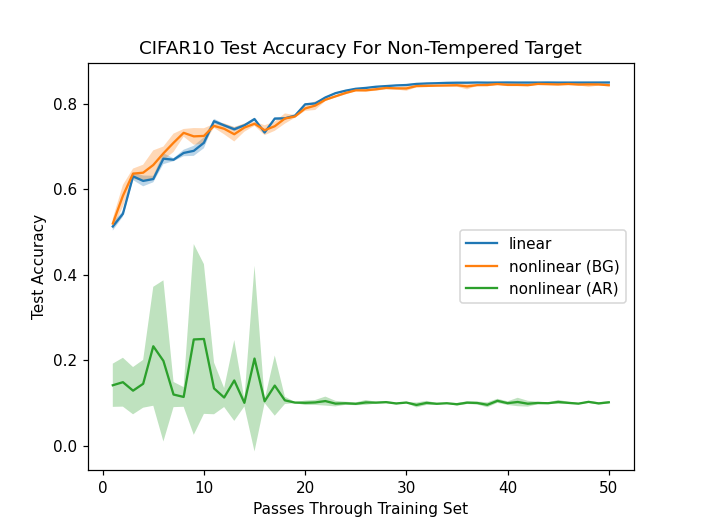

In [74]:
all_run_dirs = {
    'bg':{
        'tempered':["<all tempered runs>" ],
        'non_tempered':["<all non-tempered runs>"]
    },
    'ar':{
        'tempered':["<all tempered runs>" ],
        'non_tempered':["<all non-tempered runs>"]
    }
}

# version = 'tempered'
version = 'non_tempered'
tgt_bg_acc_df, aux_acc_df = get_all_run_logs(RUN_DIRS=all_run_dirs['bg'][version])
tgt_ar_acc_df, aux_acc_df = get_all_run_logs(RUN_DIRS=all_run_dirs['ar'][version])

print('tgt acc BG', tgt_bg_acc_df.mean(axis=1).iloc[-1], tgt_bg_acc_df.std(axis=1).iloc[-1])
print('tgt acc AR', tgt_ar_acc_df.mean(axis=1).iloc[-1], tgt_ar_acc_df.std(axis=1).iloc[-1])
print('aux acc', aux_acc_df.mean(axis=1).iloc[-1], aux_acc_df.std(axis=1).iloc[-1])

print('bg vs linear', aux_acc_df.iloc[-1].values.mean(), tgt_bg_acc_df.iloc[-1].values.mean(), 
      ttest_ind(aux_acc_df.iloc[-1].values, tgt_bg_acc_df.iloc[-1].values))
print('ar vs linear', aux_acc_df.iloc[-1].values.mean(), tgt_ar_acc_df.iloc[-1].values.mean(), 
      ttest_ind(aux_acc_df.iloc[-1].values, tgt_ar_acc_df.iloc[-1].values))

f, ax = plt.subplots()
plot_acc(ax, aux_acc_df, label='linear')
plot_acc(ax, tgt_bg_acc_df, label='nonlinear (BG)')
plot_acc(ax, tgt_ar_acc_df, label='nonlinear (AR)')
ax.set_xlabel('Passes Through Training Set')
ax.set_ylabel('Test Accuracy')
ax.set_title('CIFAR10 Test Accuracy For Non-Tempered Target')
# ax.set_title('CIFAR10 Test Accuracy For Tempered Target')
ax.legend()

[50, 50, 50, 50, 50]


<IPython.core.display.Javascript object>


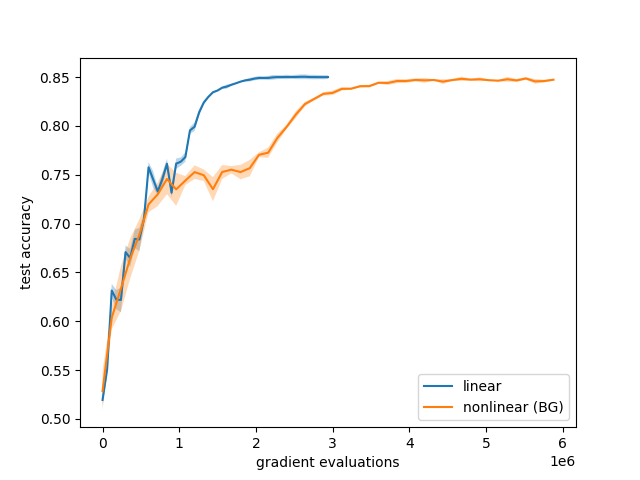

In [16]:
tgt_acc_df, aux_acc_df = get_all_run_logs()

f, ax = plt.subplots()
plot_acc_ngrads(ax, aux_acc_df, label='linear')
plot_acc_ngrads(ax, tgt_acc_df, label='nonlinear (BG)')
ax.set_xlabel('gradient evaluations')
ax.set_ylabel('test accuracy')
ax.legend()

## Calibration analysis
<!-- From [this](https://colab.research.google.com/drive/1H_XlTbNvjxlAXMW5NuBDWhxF3F2Osg1F?usp=sharing#scrollTo=w1SAqFR7wPvs) which is from [this](https://towardsdatascience.com/neural-network-calibration-using-pytorch-c44b7221a61#:~:text=The%20Expected%20Calibration%20Error%20(ECE,discrepancy%20between%20accuracy%20and%20confidence.) -->

In [45]:
def calc_bins(preds, batch):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)
        
    labels_oneh = jax.nn.one_hot(batch['label'], 10)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

def get_metrics(preds, batch):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds, batch)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE, bins, bin_accs

import matplotlib.patches as mpatches

def draw_reliability_graph(ax, preds, batch):
    ECE, MCE, bins, bin_accs = get_metrics(preds, batch)

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
#   plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')
    ax.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
#   plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)
    ax.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
#   plt.legend(handles=[ECE_patch, MCE_patch])
    ax.legend(handles=[ECE_patch, MCE_patch])

    #plt.show()
    
#   plt.savefig('calibrated_network.png', bbox_inches='tight')
    return ECE, MCE, bins, bin_accs

#draw_reliability_graph(preds)

In [ ]:
@jax.jit
def get_probs(data, params, state):
    pred_fn = lambda p,s: net.apply(p, s, None, data, is_training=False)
    pred_fn = jax.vmap(pred_fn)

    all_test_logits, _ = pred_fn(params, state)
    probs = jnp.mean(jax.nn.softmax(all_test_logits, axis=-1), axis=0)
    return probs

def get_all_probs(params, state):
    all_probs, all_labels = [], []
    for i, batch in enumerate(tqdm.tqdm(test_batches)):
        probs = get_probs(batch, params, state)
        all_probs.append(probs)
        all_labels.append(batch['label'])
#         if i > 5: break
    
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_probs, {'label':all_labels}

In [61]:
def get_calibration_metrics_e2e(params, state):
    all_probs, all_labels = get_all_probs(params, state)
    ECE, MCE, bins, bin_accs = get_metrics(all_probs, all_labels)
    return ECE, MCE

# version = 'tempered'
version = 'non_tempered'
sampler = 'bg'
# sampler = 'ar'
all_ece_lin = []
all_ece_nonlin = []
all_mce_lin = []
all_mce_nonlin = []
for i, run_dir in enumerate(all_run_dirs[sampler][version]):
    print(run_dir)
    TGT_PARAM_PATH = os.path.join(run_dir, 'tgt_params.pkl')
    TGT_STATE_PATH = os.path.join(run_dir, 'hk_state.pkl')
    AUX_PARAM_PATH = os.path.join(run_dir, 'aux_params.pkl')
    AUX_STATE_PATH = os.path.join(run_dir, 'aux_hk_state.pkl')
    
    # for nonlinear
    tgt_params = load_pickle(TGT_PARAM_PATH)
    hk_state = load_pickle(TGT_STATE_PATH)
    
    # for linear
    aux_params = load_pickle(AUX_PARAM_PATH)
    aux_hk_state = load_pickle(AUX_STATE_PATH)

    lin_ece, lin_mce = get_calibration_metrics_e2e(aux_params, aux_hk_state)
    all_ece_lin.append(lin_ece)
    all_mce_lin.append(lin_mce)
    
    nonlin_ece, nonlin_mce = get_calibration_metrics_e2e(tgt_params, hk_state)
    all_ece_nonlin.append(nonlin_ece)
    all_mce_nonlin.append(nonlin_mce)

print(f"sampler=linear |"
      f" | ECE={np.mean(all_ece_lin):.4f}+/-{np.std(all_ece_lin):.4f}"
      f" | MCE={np.mean(all_mce_lin):.4f}+/-{np.std(all_mce_lin):.4f}")
print(f"sampler={sampler} | version = {version}"
      f" | ECE={np.mean(all_ece_nonlin):.4f}+/-{np.std(all_ece_nonlin):.4f}"
      f" | MCE={np.mean(all_mce_nonlin):.4f}+/-{np.std(all_mce_nonlin):.4f}")
ece_ttest = ttest_ind(all_ece_nonlin, all_ece_lin)
mce_ttest = ttest_ind(all_mce_nonlin, all_mce_lin)
print(f"ECE t-test: p-value={ece_ttest.pvalue:.5f}")
print(f"mCE t-test: p-value={mce_ttest.pvalue:.5f}")

../../development_work2/cifar10/runs/run_2022-04-19_22-00-58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:23<00:00,  1.69it/s]


../../development_work2/cifar10/runs/run_2022-04-19_23-23-56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:22<00:00,  1.72it/s]


../../development_work2/cifar10/runs/run_2022-04-20_00-47-12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:22<00:00,  1.72it/s]


../../development_work2/cifar10/runs/run_2022-04-20_02-10-12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:22<00:00,  1.72it/s]


../../development_work2/cifar10/runs/run_2022-04-20_03-33-47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:22<00:00,  1.72it/s]


sampler=linear | | ECE=0.0024+/-0.0002 | MCE=0.0378+/-0.0043
sampler=bg | version = non_tempered | ECE=0.0014+/-0.0003 | MCE=0.0321+/-0.0075
ECE t-test: p-value=0.00063
mCE t-test: p-value=0.22143


In [58]:
print(f"sampler=linear |"
      f" | ECE={np.mean(all_ece_lin):.4f}+/-{np.std(all_ece_lin):.4f}"
      f" | MCE={np.mean(all_mce_lin):.4f}+/-{np.std(all_mce_lin):.4f}")
print(f"sampler={sampler} | version = {version}"
      f" | ECE={np.mean(all_ece_nonlin):.4f}+/-{np.std(all_ece_nonlin):.4f}"
      f" | MCE={np.mean(all_mce_nonlin):.4f}+/-{np.std(all_mce_nonlin):.4f}")
ece_ttest = ttest_ind(all_ece_nonlin, all_ece_lin)
mce_ttest = ttest_ind(all_mce_nonlin, all_mce_lin)
print(f"ECE t-test: p-value={ece_ttest.pvalue:.5f}")
print(f"mCE t-test: p-value={mce_ttest.pvalue:.5f}")

# all_ece_lin

sampler=linear | | ECE=0.0026+/-0.0002 | MCE=0.0488+/-0.0086
sampler=bg | version = tempered | ECE=0.0016+/-0.0003 | MCE=0.0372+/-0.0040
ECE t-test: p-value=0.00028
mCE t-test: p-value=0.03953


[0.0026147835858958022,
 0.002716933432365736,
 0.0025057744027482173,
 0.0023961100806795584,
 0.002843824307264864]

## OOD Analaysis

In [72]:
svhn_train, svhn_test = get_svhn_dataset(batch_size=256)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [10]:
# accuracy(tgt_params, next(test_batches))
accuracy(tgt_params, hk_state, next(iter(svhn_test)))

DeviceArray(0.09570312, dtype=float32)

<IPython.core.display.Javascript object>


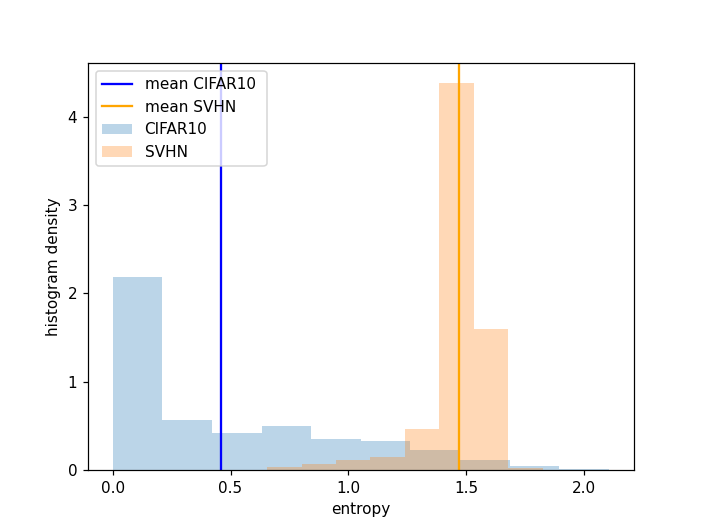

 40%|█████████████████████████████████████████████████████████████▊                                                                                              | 40/101 [02:16<03:28,  3.41s/it]


Text(0, 0.5, 'histogram density')

In [73]:
def get_all_probs2(params, state, dataset=test_batches):
    all_probs, all_labels = [], []
    for i, batch in enumerate(tqdm.tqdm(dataset)):
        probs = get_probs(batch, params, state)
        all_probs.append(probs)
        all_labels.append(batch['label'])
        if i > 39: break
    
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_probs, {'label':all_labels}

def do_ood_analysis(ax, params, state):
    # ========= mnist ==========
    ind_test_data = next(iter(test_batches))
    pred_fn = lambda p,s: net.apply(p, s, None, ind_test_data, is_training=False)
    pred_fn = jax.vmap(pred_fn)

#     all_ind_logits, _ = pred_fn(params, state)
#     ind_probs = jnp.mean(jax.nn.softmax(all_ind_logits, axis=-1), axis=0)
    ind_probs, _ = get_all_probs2(params, state, dataset=test_batches)

    ind_entropies = jax_bayes.utils.entropy(ind_probs)
    mean_ind_ent = jnp.mean(ind_entropies)

    # ======== fashion mnist =========
    ood_test_data = next(iter(svhn_test))
    pred_fn = lambda p,s: net.apply(p, s, None, ood_test_data, is_training=False)
    pred_fn = jax.vmap(pred_fn)

#     all_ood_logits, _ = pred_fn(params, state)
#     ood_probs = jnp.mean(jax.nn.softmax(all_ood_logits, axis=-1), axis=0)
    ood_probs, _ = get_all_probs2(params, state, dataset=svhn_test)

    ood_entropies = jax_bayes.utils.entropy(ood_probs)
    mean_ood_ent = jnp.mean(ood_entropies)

    
    ax.hist(np.array(ind_entropies), alpha=0.3, label='CIFAR10', density=True)
    ax.hist(np.array(ood_entropies), alpha=0.3, label='SVHN', density=True)
    ax.axvline(x=mean_ind_ent, color='blue', label='mean CIFAR10 ')
    ax.axvline(x=mean_ood_ent, color='orange', label='mean SVHN')
    
f, ax = plt.subplots()
# do_ood_analysis(ax, tgt_params, hk_state)
do_ood_analysis(ax, aux_params, aux_hk_state)
ax.legend()
ax.set_xlabel("entropy")
ax.set_ylabel("histogram density")

<IPython.core.display.Javascript object>


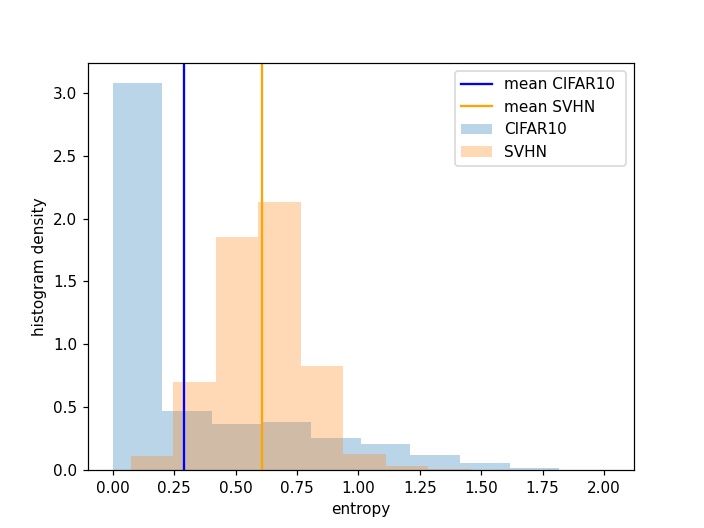

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:18<00:00,  5.32it/s]


Text(0, 0.5, 'histogram density')

In [28]:
def get_all_det_probs(params, state, dataset=test_batches):
    all_probs, all_labels = [], []
    for i, batch in enumerate(tqdm.tqdm(dataset)):
        pred_fn = lambda p,s: net.apply(p, s, None, batch, is_training=False)
        logits, _ = pred_fn(params, state)
        probs = jax.nn.softmax(logits, axis=-1)

        all_probs.append(probs)
        all_labels.append(batch['label'])
#         if i > 5: break
    
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_probs, {'label':all_labels}

def do_deterministic_ood_analysis(ax, params, state):
    # ========= mnist ==========
    ind_test_data = next(iter(test_batches))
    pred_fn = lambda p,s: net.apply(p, s, None, ind_test_data, is_training=False)

#     all_ind_logits, _ = pred_fn(params, state)
#     ind_probs = jnp.mean(jax.nn.softmax(all_ind_logits, axis=-1), axis=0)
    ind_probs, _ = get_all_det_probs(params, state, dataset=test_batches)

    ind_entropies = jax_bayes.utils.entropy(ind_probs)
    mean_ind_ent = jnp.mean(ind_entropies)

    # ======== fashion mnist =========
    ood_test_data = next(iter(svhn_test))
    pred_fn = lambda p,s: net.apply(p, s, None, ood_test_data, is_training=False)
#     pred_fn = jax.vmap(pred_fn)

#     all_ood_logits, _ = pred_fn(params, state)
#     ood_probs = jnp.mean(jax.nn.softmax(all_ood_logits, axis=-1), axis=0)
#     ood_probs, _ = get_all_probs2(params, state, dataset=svhn_test)
    ood_probs, _ = get_all_det_probs(params, state, dataset=svhn_test)

    ood_entropies = jax_bayes.utils.entropy(ood_probs)
    mean_ood_ent = jnp.mean(ood_entropies)

    
    ax.hist(np.array(ind_entropies), alpha=0.3, label='CIFAR10', density=True)
    ax.hist(np.array(ood_entropies), alpha=0.3, label='SVHN', density=True)
    ax.axvline(x=mean_ind_ent, color='blue', label='mean CIFAR10 ')
    ax.axvline(x=mean_ood_ent, color='orange', label='mean SVHN')
    
# DET_RUN_DIR = 'deterministic_runs/run_2022-05-05_22-28-40'
DET_RUN_DIR = 'deterministic_runs/run_2022-05-07_17-17-38'
TGT_PARAM_PATH = os.path.join(DET_RUN_DIR, 'params.pkl')
TGT_STATE_PATH = os.path.join(DET_RUN_DIR, 'hk_state.pkl')

det_tgt_params = load_pickle(TGT_PARAM_PATH)
det_hk_state = load_pickle(TGT_STATE_PATH)

f, ax = plt.subplots()
do_deterministic_ood_analysis(ax, det_tgt_params, det_hk_state)
ax.legend()
ax.set_xlabel("entropy")
ax.set_ylabel("histogram density")